<a href="https://colab.research.google.com/github/IndoNLP/nusax/blob/main/code/notebook/sentiment_analysis_nusax_classical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A code to train sentiment analysis for NusaX dataset.

Simply `runtime > run all` to train and test.

# Training code

In [1]:
# grab the data first
!git clone https://github.com/IndoNLP/nusax.git

Cloning into 'nusax'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 301 (delta 4), reused 2 (delta 2), pack-reused 296 (from 1)
Receiving objects: 100% (301/301), 3.74 MiB | 19.25 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [2]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
import pandas as pd
from nltk import word_tokenize


# read csv data
# return a pair of (list of data, list of label)
# also tokenize the input first
def load_data(filedir):
    df = pd.read_csv(filedir, encoding='utf-8-sig')
    data = list(df['text'])
    # if lang :
    #   data = list(df[lang])
    data = [" ".join(word_tokenize(sent)) for sent in data]
    return (data, list(df['label']))



In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from scipy.sparse import vstack
import matplotlib.pyplot as plt

import numpy as np

def hyperparam_tuning(xtrain, ytrain, xvalid, yvalid, classifier, param_grid):
    # combine train and valid
    x = vstack([xtrain, xvalid])
    y = ytrain + yvalid

    # create predefined split
    # -1 for all training and 0 for all validation
    ps = PredefinedSplit([-1] * len(ytrain) + [0] * len(yvalid))
    clf = GridSearchCV(classifier, param_grid, cv = ps)
    clf = clf.fit(x, y)

    return clf


def train_and_test(lang, feature="bow", classifier="nb"):

    directory = "nusax/datasets/sentiment/"
    xtrain, ytrain = load_data(directory + lang +"/train.csv")
    xvalid, yvalid = load_data(directory + lang + "/valid.csv")
    xtest, ytest = load_data(directory + lang + "/test.csv")

    # train feature on train data
    if feature == "bow":
        vectorizer = CountVectorizer()
    elif feature == "tfidf":
        vectorizer = TfidfVectorizer()
    else:
        raise Exception('Vectorizer unknown. Use "bow" or "tfidf"')
    vectorizer.fit(xtrain)

    # transform
    xtrain = vectorizer.transform(xtrain)
    xvalid = vectorizer.transform(xvalid)
    xtest = vectorizer.transform(xtest)

    # all classifiers
    classifier_model = {
        "nb" : MultinomialNB(),
                        "svm": SVC(probability=True),
                        "lr" : LogisticRegression(),
                       }
    # all params for grid-search
    param_grids = {
        # "nb" : {"alpha": np.linspace(0.001,1,50)},
                   "svm": {'C': [1], 'kernel': ['linear']},
                  #  "svm": {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']},
                  #  "lr" : {'C': np.linspace(0.001,10,100)},
                  }

    clf = hyperparam_tuning(xtrain, ytrain, xvalid, yvalid,
                            classifier=classifier_model[classifier],
                            param_grid=param_grids[classifier])

    pred = clf.predict(xtest.toarray())
    f1score = f1_score(ytest,pred, average='macro')

    return f1score, clf, vectorizer

# Testing

In [5]:
language = "indonesian"

In [6]:
print(f"Training for sentiment analysis classifier {language}")
f1, clf, vectorizer = train_and_test(language, feature="tfidf", classifier="svm")
print(f"Training done. F1 on test set is {f1}")
clf

Training for sentiment analysis classifier indonesian
Training done. F1 on test set is 0.7867500264545731


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(probability=True),
             param_grid={'C': [1], 'kernel': ['linear']})

In [7]:
best_model = clf.best_estimator_
print(best_model)

# Best parameters
best_params = clf.best_params_
print("Best params:", clf.best_params_)

# Best score
print("Best CV score:", clf.best_score_)

SVC(C=1, kernel='linear', probability=True)
Best params: {'C': 1, 'kernel': 'linear'}
Best CV score: 0.76


# LIME example

In [8]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2fa7e50450516e62a12ccb5575bb343bc0394a004986726cd04a407f36bc586b
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [9]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, best_model)


In [10]:
best_model

SVC(C=1, kernel='linear', probability=True)

In [11]:
from lime.lime_text import LimeTextExplainer
class_names = ['negative', 'neutral', 'positive']
explainer = LimeTextExplainer(class_names=class_names, random_state=42)

In [12]:
directory = "nusax/datasets/sentiment/"
xtest, ytest = load_data(directory + language + "/test.csv")

In [13]:
idx = 0
exp = explainer.explain_instance(xtest[idx], c.predict_proba, num_features=6, labels= list(range(0, 3)))
print('Document id: %d' % idx)
print('Text: %s' % xtest[idx])
X_test_tfidf = vectorizer.transform(xtest)
print('Predicted class =', clf.predict(X_test_tfidf[idx]))# class_names[])# .reshape(1,-1)[0,0]])
print('True class: %s' % ytest[idx])

Document id: 0
Text: Dekat dengan hotel saya menginap , hanya ditempuh jalan kaki , di sini banyak sekali pilihan makanannya , tempat yang luas , dan menyenangkan
Predicted class = ['positive']
True class: positive


In [14]:
for attr, value in exp.__dict__.items():
    print(f"{attr} = {value}")

random_state = RandomState(MT19937)
mode = classification
domain_mapper = <lime.lime_text.TextDomainMapper object at 0x7a35197b6450>
local_exp = {0: [(np.int64(13), np.float64(-0.10738889665712974)), (np.int64(19), np.float64(-0.09097078625227023)), (np.int64(2), np.float64(0.0832518145688738)), (np.int64(9), np.float64(-0.08287701974030652)), (np.int64(10), np.float64(-0.07452068369107014)), (np.int64(12), np.float64(0.0734484812778625))], 1: [(np.int64(15), np.float64(-0.07132757512803566)), (np.int64(12), np.float64(-0.05882201548837778)), (np.int64(14), np.float64(-0.05685751214841555)), (np.int64(18), np.float64(-0.05409296767598953)), (np.int64(19), np.float64(-0.05139273419564318)), (np.int64(4), np.float64(0.04136528798764629))], 2: [(np.int64(19), np.float64(0.13748835372674442)), (np.int64(15), np.float64(0.122549543464387)), (np.int64(10), np.float64(0.11356901917607032)), (np.int64(13), np.float64(0.11191246241522004)), (np.int64(18), np.float64(0.10446313927584465)), (np.i

In [15]:
exp.as_map()

{0: [(np.int64(13), np.float64(-0.10738889665712974)),
  (np.int64(19), np.float64(-0.09097078625227023)),
  (np.int64(2), np.float64(0.0832518145688738)),
  (np.int64(9), np.float64(-0.08287701974030652)),
  (np.int64(10), np.float64(-0.07452068369107014)),
  (np.int64(12), np.float64(0.0734484812778625))],
 1: [(np.int64(15), np.float64(-0.07132757512803566)),
  (np.int64(12), np.float64(-0.05882201548837778)),
  (np.int64(14), np.float64(-0.05685751214841555)),
  (np.int64(18), np.float64(-0.05409296767598953)),
  (np.int64(19), np.float64(-0.05139273419564318)),
  (np.int64(4), np.float64(0.04136528798764629))],
 2: [(np.int64(19), np.float64(0.13748835372674442)),
  (np.int64(15), np.float64(0.122549543464387)),
  (np.int64(10), np.float64(0.11356901917607032)),
  (np.int64(13), np.float64(0.11191246241522004)),
  (np.int64(18), np.float64(0.10446313927584465)),
  (np.int64(2), np.float64(-0.09581206758557806))]}

In [16]:
weights_dict = {}
for i,label in enumerate(class_names):
  weight_list = exp.as_list(label=i)
  ans = [(str(x[0]), float(x[1])) for x in weight_list]
  weights_dict[i] = ans
weights_dict

{0: [('pilihan', -0.10738889665712974),
  ('menyenangkan', -0.09097078625227023),
  ('hotel', 0.0832518145688738),
  ('di', -0.08287701974030652),
  ('sini', -0.07452068369107014),
  ('sekali', 0.0734484812778625)],
 1: [('tempat', -0.07132757512803566),
  ('sekali', -0.05882201548837778),
  ('makanannya', -0.05685751214841555),
  ('dan', -0.05409296767598953),
  ('menyenangkan', -0.05139273419564318),
  ('menginap', 0.04136528798764629)],
 2: [('menyenangkan', 0.13748835372674442),
  ('tempat', 0.122549543464387),
  ('sini', 0.11356901917607032),
  ('pilihan', 0.11191246241522004),
  ('dan', 0.10446313927584465),
  ('hotel', -0.09581206758557806)]}

In [17]:
# function copied from lime explanations object
def as_pyplot_figure(weights_dict, class_names ,  label=1, figsize=(4,4)):
  """Returns the explanation as a pyplot figure.

  Will throw an error if you don't have matplotlib installed
  Args:
      label: desired label. If you ask for a label for which an
              explanation wasn't computed, will throw an exception.
              Will be ignored for regression explanations.
      figsize: desired size of pyplot in tuple format, defaults to (4,4).
      kwargs: keyword arguments, passed to domain_mapper

  Returns:
      pyplot figure (barchart).
  """
  import matplotlib.pyplot as plt
  exp = weights_dict[label]
  fig = plt.figure(figsize=figsize)
  vals = [x[1] for x in exp]
  names = [x[0] for x in exp]
  vals.reverse()
  names.reverse()
  colors = ['green' if x > 0 else 'red' for x in vals]
  pos = np.arange(len(exp)) + .5
  plt.barh(pos, vals, align='center', color=colors)
  plt.yticks(pos, names)
  title = 'Local explanation for class %s' % class_names[label]
  plt.title(title)
  return fig

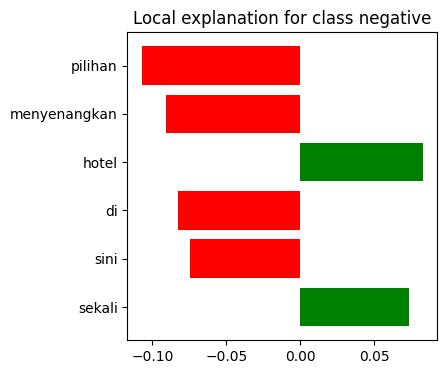

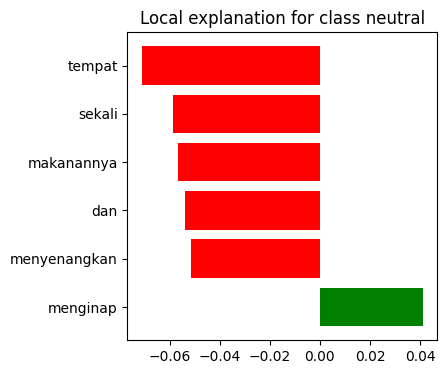

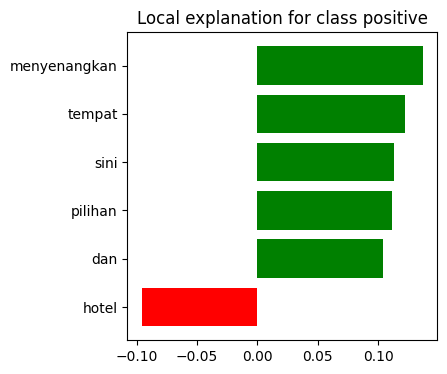

In [18]:
for i in range(len(class_names)):
  fig = as_pyplot_figure(weights_dict, class_names, label=i)

# Add LIME Weights into pandas

In [19]:
languages = ['acehnese','balinese', 'banjarese', 'buginese' ,  'english' , 'indonesian' , 'javanese', 'madurese', 'minangkabau', 'ngaju', 'sundanese' ,'toba_batak']
print (len(languages))

12


In [20]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

import ast

def predict_proba_to_pred_label(x):
  lst = ast.literal_eval(x)   # returns [0.2, 0.3, 0.5]
  arr = np.array(lst, dtype=float)

  idx = np.argmax(arr)
  labels = ["negative", "neutral", "positive"]
  predicted_label = labels[idx]

  return predicted_label

def get_lime_weights(x, c):
  text = x['text']
  exp = explainer.explain_instance(text, c.predict_proba, num_features=6, labels= list(range(0, 3)))
  weights_dict = {}
  for i,label in enumerate(class_names):
    weight_list = exp.as_list(label=i)
    ans = [(str(x[0]), float(x[1])) for x in weight_list]
    weights_dict[label] = ans
  return weights_dict

def heavy_task(id):
  lang = languages[id]
  print(f"Training for sentiment analysis classifier {lang}")
  f1, clf, vectorizer = train_and_test(lang, feature="tfidf", classifier="svm")
  print(clf.best_estimator_)
  print(f"Training done. F1 on {lang} test set is {f1}")

  directory = "nusax/datasets/sentiment/"

  c = make_pipeline(vectorizer, clf)
  class_names = ['negative', 'neutral', 'positive']
  explainer = LimeTextExplainer(class_names=class_names, random_state=42)

  df_test = pd.read_csv(directory + lang + "/test.csv", encoding='utf-8-sig')

  df_test["predict_proba"] = df_test["text"].apply(lambda x: c.predict_proba([x])[0].tolist())
  print(f"Add predict proba done")

  df_test["predict_label"] = df_test.apply(lambda x: predict_proba_to_pred_label(x["predict_proba"]), axis=1)

  df_test['lime_weights'] = df_test.apply(get_lime_weights, axis=1, c=c)
  print(f"Add LIME weights done")

  df_test.to_csv(lang + "_results.csv", sep=';' , index=False)



In [21]:
results = True

# Start create csv with lime weights
if results == False :
  for i,language in enumerate(languages):
    heavy_task(i)

In [22]:
plt.close('all')

# Read CSV and plot lime weights

In [23]:
language = "indonesian"
df = pd.read_csv(language + "_results.csv", sep=";")

In [24]:
df.head()

,id,text,label,predict_proba,predict_label,lime_weights
0,411,"Dekat dengan hotel saya menginap, hanya ditemp...",positive,"[0.04394736264166428, 0.022015100692630574, 0....",positive,"{'negative': [('pilihan', -0.10872026438818967..."
1,729,"Iya benar, dia sedang jaga warung.",neutral,"[0.0232314608896576, 0.9732814004297543, 0.003...",neutral,"{'negative': [('dia', -0.059181567007571864), ..."
2,373,Kangkungnya lumayan tapi kepiting saus padangn...,negative,"[0.7607990721305844, 0.10790971522834425, 0.13...",negative,"{'negative': [('tidak', 0.309200266155834), ('..."
3,262,Bertempat di braga city walk yang satu gedung ...,positive,"[0.018689484652965688, 0.004434581276743902, 0...",positive,"{'negative': [('yang', -0.06788845966848119), ..."
4,177,Gianyar terima bantuan sosial 2018 sebesar rp ...,neutral,"[0.11583473929565392, 0.8286203082355317, 0.05...",neutral,"{'negative': [('terima', -0.1504803896990044),..."


In [25]:
f1score_df = f1_score(df["label"],df["predict_label"], average='macro')
print(f1score_df)

0.7899403397503288


In [26]:
lime_weights = df["lime_weights"].iloc[0]

In [27]:
lime_weights_dict = ast.literal_eval(lime_weights)
lime_weights_dict

{'negative': [('pilihan', -0.10872026438818967),
  ('menyenangkan', -0.0992290439999392),
  ('hotel', 0.0817382788383944),
  ('di', -0.07731438354793727),
  ('sekali', 0.07618056781923226),
  ('dengan', -0.07563208917772536)],
 'neutral': [('tempat', -0.06797361951194096),
  ('sekali', -0.0592971332571169),
  ('menyenangkan', -0.055727581664076875),
  ('dan', -0.05436462661451575),
  ('makanannya', -0.05247810237943239),
  ('menginap', 0.04242362921607472)],
 'positive': [('menyenangkan', 0.15003683465674975),
  ('pilihan', 0.11549169918569599),
  ('tempat', 0.11305849665510335),
  ('sini', 0.10926341692334243),
  ('dan', 0.10230495597811548),
  ('hotel', -0.09806209679886775)]}

In [28]:
lime_weights_dict["negative"]

[('pilihan', -0.10872026438818967),
 ('menyenangkan', -0.0992290439999392),
 ('hotel', 0.0817382788383944),
 ('di', -0.07731438354793727),
 ('sekali', 0.07618056781923226),
 ('dengan', -0.07563208917772536)]

In [29]:
import matplotlib.pyplot as plt

# modified as_pyplot function from LIME library
def lime_weights_to_pyplot(weights_dict, label, figsize=(4,4)):
  exp = weights_dict[label]
  fig = plt.figure(figsize=figsize)
  vals = [x[1] for x in exp]
  names = [x[0] for x in exp]
  vals.reverse()
  names.reverse()
  colors = ['green' if x > 0 else 'red' for x in vals]
  pos = np.arange(len(exp)) + .5
  plt.barh(pos, vals, align='center', color=colors)
  plt.yticks(pos, names)
  title = 'Local explanation for class %s' % label
  plt.title(title)
  return fig

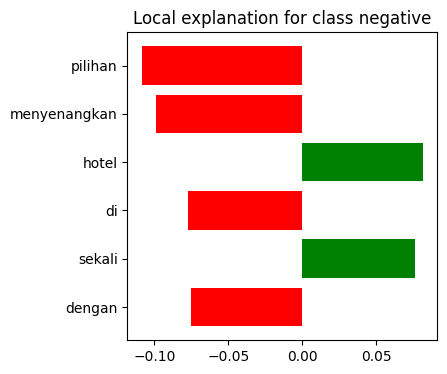

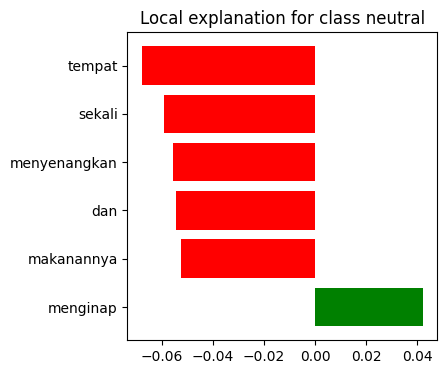

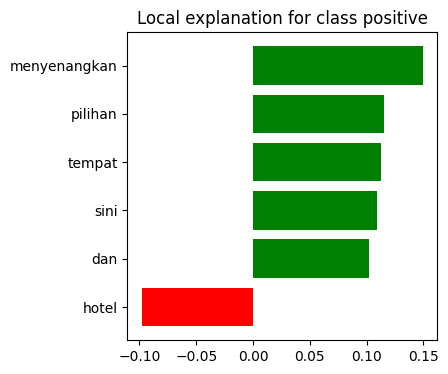

In [30]:
for label in (class_names):
  fig = lime_weights_to_pyplot(lime_weights_dict, label)